In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
seed = 10000
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./images/',
    labels='inferred',
    image_size=(128, 128),
    validation_split=0.3,
    subset='training',
    seed=seed,
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./images/',
    labels='inferred',
    image_size=(128, 128),
    validation_split=0.3,
    subset='validation',
    seed=seed,
)

Found 1997 files belonging to 2 classes.
Using 1398 files for training.
Found 1997 files belonging to 2 classes.
Using 599 files for validation.


In [3]:
# preparing model for transfer learning
# using MobileNetV2 because it is also an image classification model, and it is in the tutorial I'm using (https://www.tensorflow.org/tutorials/images/transfer_learning)

IMAGE_SHAPE = (128, 128, 3)
base_classifier = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_classifier.trainable = False

# scaling for classifier model
temp_scaling_input = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset=-1)

# scaling for when this is converted to generator
# the generator outputs values in 0, 1. The model expects -1, 1
gen_scaling_input = tf.keras.layers.experimental.preprocessing.Rescaling(2, offset=-1)

pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE)
x = temp_scaling_input(inputs)
x = base_classifier(x, training=False)
x = pooling_layer(x)
outputs = prediction_layer(x)
classifier_model = tf.keras.Model(inputs, outputs)

In [4]:
LEARNING_RATE = 1e-4

classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [5]:
EPOCHS = 10

history = classifier_model.fit(
    train_images,
    epochs=EPOCHS,
    validation_data=val_images,
)

Epoch 1/10
44/44 [==============================] - 13s 195ms/step - loss: 0.6753 - accuracy: 0.5622 - val_loss: 0.6069 - val_accuracy: 0.6311
Epoch 2/10
44/44 [==============================] - 9s 172ms/step - loss: 0.5132 - accuracy: 0.6910 - val_loss: 0.4804 - val_accuracy: 0.7513
Epoch 3/10
44/44 [==============================] - 9s 171ms/step - loss: 0.4059 - accuracy: 0.7947 - val_loss: 0.3945 - val_accuracy: 0.8197
Epoch 4/10
44/44 [==============================] - 9s 176ms/step - loss: 0.3317 - accuracy: 0.8598 - val_loss: 0.3346 - val_accuracy: 0.8564
Epoch 5/10
44/44 [==============================] - 9s 175ms/step - loss: 0.2786 - accuracy: 0.8863 - val_loss: 0.2903 - val_accuracy: 0.8648
Epoch 6/10
44/44 [==============================] - 9s 172ms/step - loss: 0.2395 - accuracy: 0.9041 - val_loss: 0.2568 - val_accuracy: 0.8831
Epoch 7/10
44/44 [==============================] - 9s 174ms/step - loss: 0.2098 - accuracy: 0.9192 - val_loss: 0.2303 - val_accuracy: 0.8965
Epoch

In [11]:
# making a generator model for generating images from random vectors

generator_model = tf.keras.models.Sequential()

V_WINDOW = 16
V_CONVOLUTIONS = 128
VECTOR_LENGTH = V_WINDOW*V_WINDOW*V_CONVOLUTIONS

generator_model.add(tf.keras.layers.InputLayer(input_shape=(VECTOR_LENGTH,)))
generator_model.add(tf.keras.layers.Reshape((V_WINDOW, V_WINDOW, V_CONVOLUTIONS)))

generator_model.add(tf.keras.layers.Conv2DTranspose(
    filters=64,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    use_bias=False,
    activation='relu', # I want activations between 0 and 1 for image representation
))

generator_model.add(tf.keras.layers.Conv2DTranspose(
    filters=32,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    use_bias=False,
    activation='relu', # I want activations between 0 and 1 for image representation
))

generator_model.add(tf.keras.layers.Conv2DTranspose(
    filters=3,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    use_bias=False,
    activation='relu', # I want activations between 0 and 1 for image representation
))

print(generator_model.output_shape)

(None, 128, 128, 3)


In [37]:
# attaching the generator as input to the frozen classifier, to teach generator what classifier wants

base_classifier.trainable = False
pooling_layer.trainable = False
prediction_layer.trainable = False
gen_scaling_input.trainable = False

full_input = tf.keras.layers.Input(shape=(VECTOR_LENGTH,))
x = generator_model(full_input)
x = gen_scaling_input(x)
x = base_classifier(x, training=False)
x = pooling_layer(x)
full_output = prediction_layer(x)

full_model = tf.keras.Model(full_input, full_output)

In [38]:
full_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [40]:
train_vectors = tf.random.normal((2000, VECTOR_LENGTH))
train_labels = tf.concat([
    tf.ones((1000, 1)),
    tf.zeros((1000, 1)),
], 0)


full_model.fit(
    x=train_vectors,
    y=train_labels,
    validation_split=0.3,
    shuffle=True,
    epochs=2,
)

Epoch 1/2
44/44 [==============================] - 6s 81ms/step - loss: 0.8544 - accuracy: 0.7136 - val_loss: 1.1089 - val_accuracy: 0.0433
Epoch 2/2
44/44 [==============================] - 3s 64ms/step - loss: 0.5956 - accuracy: 0.7121 - val_loss: 1.3515 - val_accuracy: 0.0000e+00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 127.5, 127.5, -0.5)

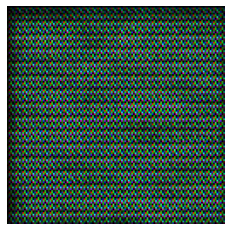

In [48]:
generated_images = generator_model(train_vectors, training=False)

plt.imshow(generated_images[1])
plt.axis('off')